100%|████████████████████████████████████| 10000/10000 [00:26<00:00, 377.37it/s]


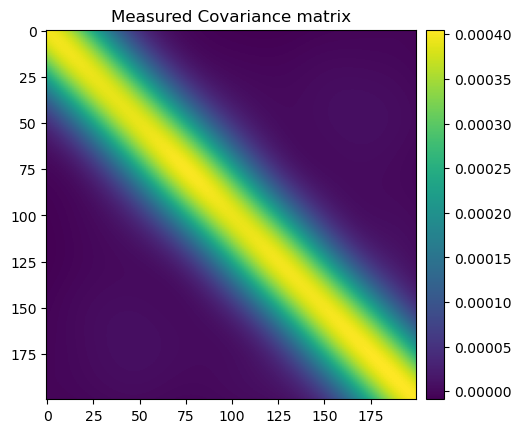

risultato giusto ==> valore differenza massimo : 2.710505431213761e-19


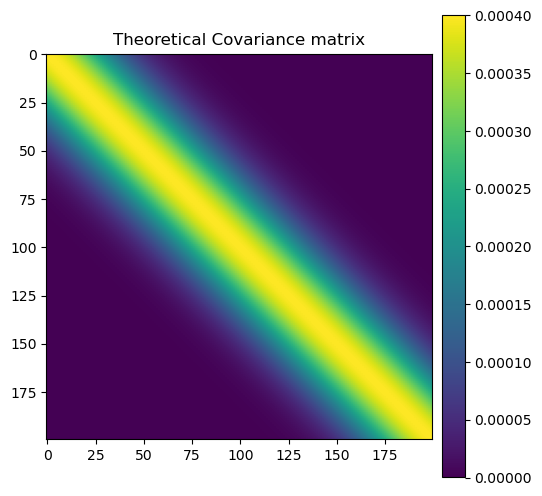

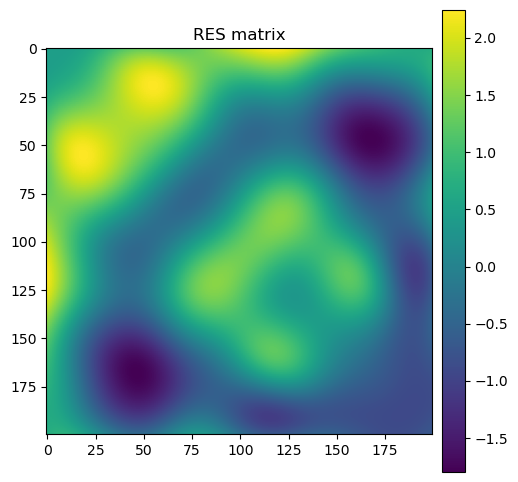

standard deviation = 0.9471380341783253


100%|████████████████████████████████████| 10000/10000 [00:25<00:00, 389.42it/s]


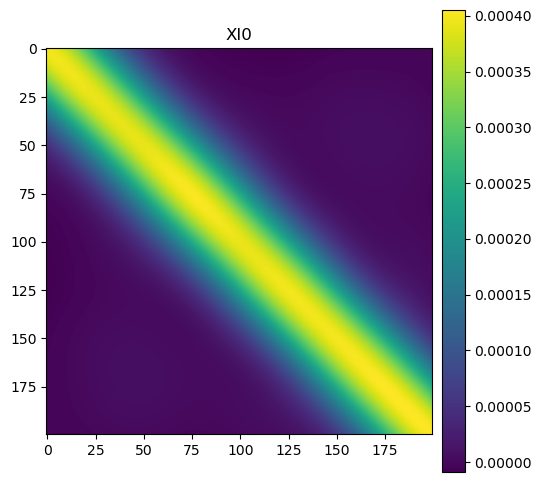

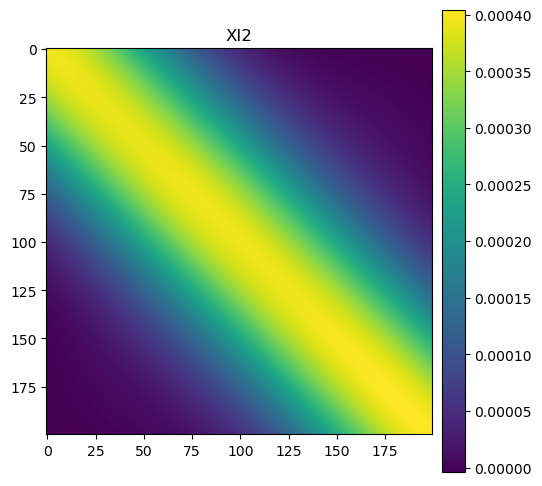

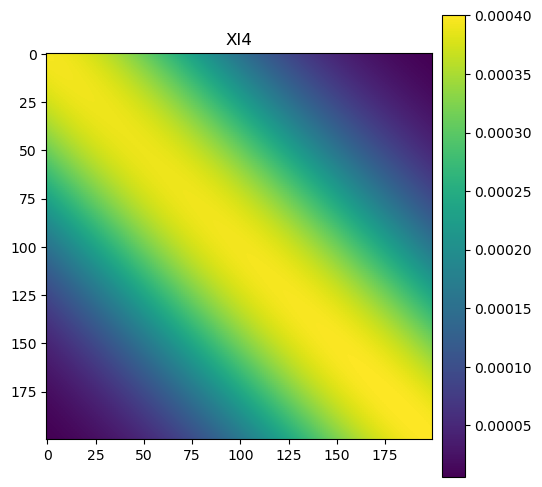

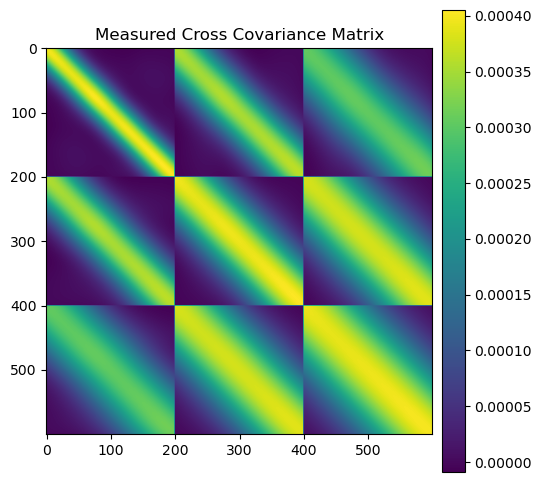

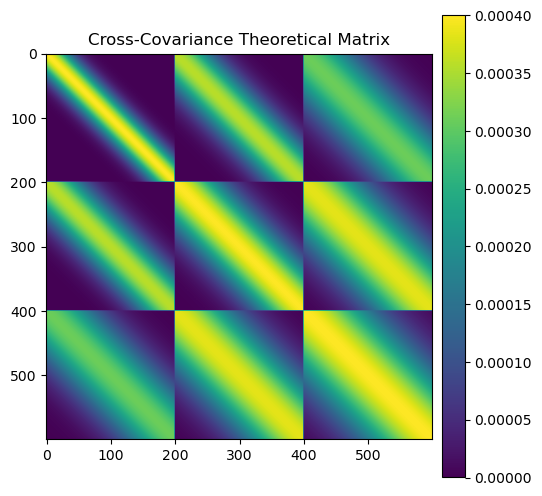

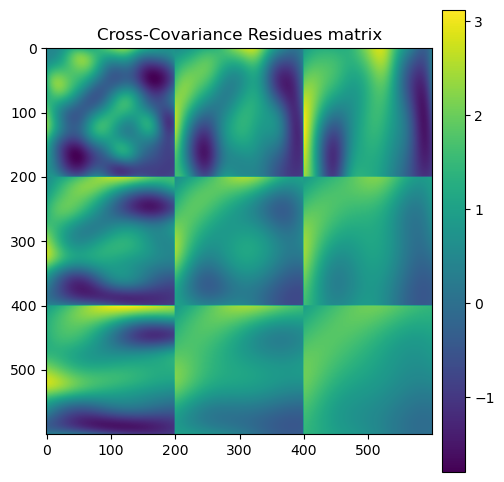

standard dev = 0.9114166373941788


In [1]:
#Codice che legge e opera sul primo set di misure (TEST_1)

import numpy as np
from astropy.io import fits
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

parametro = [
    [{'sigma':0.02, 'h':25,'rho':1.0},
    {'sigma':0.02, 'h':50,'rho':1.0},
    {'sigma':0.02, 'h':75,'rho':1.0}],
    
    [{'sigma':0.02, 'h':50,'rho':1.0},
    {'sigma':0.01, 'h':50,'rho':1.0},
    {'sigma':0.005, 'h':50,'rho':1.0}],
    
    [{'sigma':0.02, 'h':5,'rho':1.0},
    {'sigma':0.01, 'h':5,'rho':1.0},
    {'sigma':0.005, 'h':5,'rho':1.0}]
    ]
#parametri forniti dal testo dell'esercizio, riferiti al primo, secondo e terzo file.


def Leggi(N_measures, test, multipolo):#funzione che legge i files scaricati
    measures=[]
    for i in tqdm(np.arange(N_measures)+1): #intero che va in una lista
        fname=f'/Users/mariachiaracorsi/Desktop/esercizioAbilità/data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_MULTIPOLES_Test{test}_{i}.fits'
        #print(f' apro il file N. {i} chiamato {fname}'). In base al valore della variabile test, apre file diversi.

        file=fits.open(fname)
        table=file[1].data.copy()
        measures.append(table[multipolo])
        if i==1:
            scale=table['SCALE']
        del table #per non appesantire il programma
        file.close()
    return np.array(measures), np.array(scale)


def Covariance(matrice,mean=False):# funzione covarianza misurata(opera in base alla definizione di covarianza)
    MEAN = matrice.mean(axis=0)
    dim_matrice = len(matrice[0,:])
    M=[]
    for i in range(dim_matrice):
        M.append(matrice[:,i]-MEAN[i])
    M=np.array(M)
    cov=np.matmul(M,M.T)
    if mean:
        return MEAN, cov
    else:
        return np.array(cov)/(len(matrice[:,0])-1)

def correlationmatrix(matrice):#funzione di correlazione, segue dalla definizione (data dalle slides delle lezioni)
    dim_matrice=matrice.shape
    diag=np.diag(matrice)
    COV=np.zeros(dim_matrice)
    for l1 in range(dim_matrice[0]):
        for l2 in range(dim_matrice[1]):
            COV[l1,l2]=matrice[l1,l2]/np.sqrt(diag[l1]*diag[l2])
    return COV

def Th_Covariance(r,multipolo,parametro):# funzione di covarianza teorica per singolo multipolo
    dim=len(r)
    m_1=multipolo[0]
    m_2=multipolo[1]
    COV=np.zeros((dim,dim))
    if (multipolo[0]==multipolo[1]):
        for k in range(dim):
            for j in range(dim):
                COV[k,j] = (parametro[m_1]['sigma']**2)*np.exp(-((r[k]-r[j])**2)/(2*parametro[m_1]['h']**2))
        return COV
    elif (multipolo[0] != multipolo[1]):
        for k in range(dim):
            for j in range(dim):
                COV[k,j] = (parametro[m_1]['sigma']*parametro[m_2]['sigma'])*np.sqrt((2*parametro[m_1]['h']*parametro[m_2]['h'])/(parametro[m_1]['h']**2+parametro[m_2]['h']**2))*np.exp(-((r[k]-r[j])**2)/(parametro[m_1]['h']**2+parametro[m_2]['h']**2))
        return COV
                
def Res(th_covariance,covariance,N_measures,N_bins = 200):# funzione Residui che ha in ingresso la covarianza teorica e quella misurata e le confronta 
    Th_Correlation = correlationmatrix(th_covariance)
    RES = np.zeros((N_bins,N_bins))
    diag = np.diag(th_covariance)
    for k in range(N_bins):
        for j in range(N_bins):
            RES[k,j] = (th_covariance[k,j] - covariance[k,j])*np.sqrt((N_measures-1)/((1+Th_Correlation[k,j])*diag[k]*diag[j]))
    return RES  


def Cross_covariance(matrice):#funzione della cross-covarianza (Matrice 3x3, ogni elemento è una matrice a sua volta)
    M = [[],[],[]]
    cov = []
    for j in range(len(matrice)):
        MEAN = matrice[j].mean(axis = 0)
        dim_matrice = len(matrice[j][0,:])
        
        for i in range(dim_matrice):
            M[j].append(matrice[j][:,i]-MEAN[i])
        M[j] = np.array(M[j])
        del MEAN
    for k in range(3):
        for h in range(3):
            cov.append(np.matmul(M[k],M[h].T)/(len(matrice[0][:,0])-1))
    
    return np.array(cov)

def blocchi(matrice):#crea la struttura a blocchi della matrice 3x3
    primo = np.concatenate(matrice[0:3])
    secondo = np.concatenate(matrice[3:6])
    terzo = np.concatenate(matrice[6:9])
    
    return np.concatenate((primo,secondo,terzo),axis=1)

def Res_Cross(th_matrice,matrice,N_measures,N_bins = 200):#calcola i residui tra matrice misurata e quella teorica
    RES = []
    for i in range(9):
        RES.append(Res(th_matrice[i],matrice[i],N_measures))
        
    return np.array(RES)

def Th_Cross_Covariance(matrice,parametro):#Matriec 3x3 dei valori teorici
    Theoretical_Cross_Correlation = []
    for i in range(3):
        for j in range(3):
            Theoretical_Cross_Correlation.append(Th_Covariance(matrice[i],[i,j],parametro))
        
    return np.array(Theoretical_Cross_Correlation)

# da questo punto in poi del codice, si richiamano le funzioni, passando i parametri desiderati

N_measures= 10000
N_bins=200
measures,r= Leggi(N_measures = N_measures,test = 1,multipolo = 'XI0')

COV = np.cov(measures.T) #misure trasposte
MEASUREDCOV = Covariance(measures)
plt.imshow(MEASUREDCOV)
plt.title('Measured Covariance matrix')
cbar = plt.colorbar(orientation="vertical", pad=0.02)
plt.show()
#verifico deviazione standard
devstand = 1e-15
MAX_DIFF = np.max(np.abs(COV-MEASUREDCOV))
if MAX_DIFF < devstand:
    print(f'risultato giusto ==> valore differenza massimo : {MAX_DIFF}')
else:
    print(f'WARNING: max difference {MAX_DIFF} > {devstand}')   

#matrice covarianza teorica

TH_COV = Th_Covariance(r,[0,0],parametro[0])
fig = plt.figure(figsize=(6,6))
plt.title('Theoretical Covariance matrix')
plt.imshow(TH_COV)
cbar = plt.colorbar(orientation="vertical", pad=0.02)


#Calcolo Residui


TH_COV = Th_Covariance(r,[0,0],parametro[0])
RES = Res(TH_COV,COV,N_measures)
fig = plt.figure(figsize=(6,6))
plt.title('RES matrix')
plt.imshow(RES)
cbar = plt.colorbar(orientation="vertical", pad=0.02)

plt.show()

print(f'standard deviation = {np.std(RES.reshape(200*200))}')



N_measures = 10000
TEST_NUMBER = 1
lista_multipoli = ['XI0','XI2','XI4']
data_r = []
data_measures = []
for k in lista_multipoli:
    temp0,temp1 = Leggi(N_measures = N_measures,test = TEST_NUMBER,multipolo = k)
    data_r.append(temp1)
    data_measures.append(temp0)
    del temp0
    del temp1


COVARIANCE = []
CORRELATION = []
for i in range(len(data_measures)):
    COVARIANCE.append(Covariance(data_measures[i]))
    CORRELATION.append(correlationmatrix(COVARIANCE[i]))
    fig = plt.figure(figsize=(6,6))
    plt.title(lista_multipoli[i])
    plt.imshow(COVARIANCE[i])
    cbar = plt.colorbar(orientation="vertical", pad=0.02)
    

plt.show()
   



# Matrice 3x3  valori misurati

TOT_COVARIANCE = Cross_covariance(data_measures)
BLOCK_COVARIANCE = blocchi(TOT_COVARIANCE)
fig = plt.figure(figsize=(6,6))
plt.title('Measured Cross Covariance Matrix')
plt.imshow(BLOCK_COVARIANCE)
cbar = plt.colorbar(orientation="vertical", pad=0.02)


plt.show()

# Matrice 3x3  valori teorici


test = TEST_NUMBER-1
TH_CROSS_COV = Th_Cross_Covariance(data_r,parametro[test])
BLOCK_CROSS_COVARIANCE = blocchi(TH_CROSS_COV)
fig = plt.figure(figsize=(6,6))
plt.title('Cross-Covariance Theoretical Matrix')
plt.imshow(BLOCK_CROSS_COVARIANCE)
cbar = plt.colorbar(orientation="vertical", pad=0.02)


plt.show()


# Cross-residuals

CROSS_RES = Res_Cross(TH_CROSS_COV,TOT_COVARIANCE,N_measures)
fig = plt.figure(figsize=(6,6))
plt.title('Cross-Covariance Residues matrix')
BLOCK_RES_COVARIANCE = blocchi(CROSS_RES)
plt.imshow(BLOCK_RES_COVARIANCE)
cbar = plt.colorbar(orientation="vertical", pad=0.02)

plt.show()
print(f'standard dev = {np.std(CROSS_RES.reshape(600*600))}')







